In [1]:
%matplotlib inline

In [2]:
from importlib import reload
import nb_import
nb_import = reload(nb_import)

In [3]:
from nb_import import *

# Report

## 1. Abstract

This notebook constitutes a short report of the activities that I conducted during the 2-months position. The present notebook present some of the inner details of t-SNE: how it addresses the crowding problem and how the cost gradient looks like for a pair of points as a function of perplexity and early exaggeration. Force-based algorithms are then presented, as well as the gradient for different types of cost. A short discussion about the similarities and differences follows before looking at the different optimisations that have been proposed and implemented for t-SNE. Finally, reflecting on some findings based on the literature, a short list of research opportunities is proposed.

The second notebook is available here: [Experiments Notebook](experiments.ipynb). It presents the results for the different experiments I conducted.

## 2. t-SNE

References:
1. Maaten, L. van der, & Hinton, G. (2008). Visualizing Data using t-SNE. Journal of Machine Learning Research, 9(Nov), 2579–2605. Retrieved from http://www.jmlr.org/papers/v9/vandermaaten08a.html
2. Maaten, L. van der. (2014). Accelerating t-SNE using Tree-Based Algorithms. Journal of Machine Learning Research, 15, 3221–3245. Retrieved from http://jmlr.org/papers/v15/vandermaaten14a.html

t-SNE is a dimensionality reduction technique which has been proposed by Van der Maaten [1,2].

[1] describes the technique in relation to other non-linear embedding methods, such as "(1) Sammon mapping (Sammon, 1969), (2) curvilinear components analysis (CCA; Demartines and Hérault, 1997), (3) Stochastic Neighbor Embedding (SNE; Hinton and Roweis, 2002), (4) Isomap (Tenenbaum et al., 2000), (5) Maximum Variance Unfolding (MVU; Weinberger et al., 2004), (6) Locally Linear Embedding (LLE; Roweis and Saul, 2000), and (7) Laplacian Eigenmaps (Belkin and Niyogi, 2002)".

In particular, the crowding problem is addressed. 
"If we want to model the small distances accurately in the map, most of the points that are at a moderate distance from datapoint i will have to be placed much too far away in the two-dimensional map. [...] An attempt to address the crowding problem by adding a slight repulsion to all springs was presented by Cook et al. (2007)." This technique called UNI-SNE was however complex to optimise.

The main idea of [1] is to propose a new distribution for the low-dimensional embedding.

The problem is defined as follows. Let us have a dataset of (high-dimensional) input objects 

$$D = {\boldsymbol x_1, \boldsymbol x_2, ... , \boldsymbol x_N}$$

and a function $d(\boldsymbol x_i, \boldsymbol x_j)$ that computes a distance between a pair of objects, e.g., the Euclidean distance $d(\boldsymbol x_i, \boldsymbol x_j) = \lVert \boldsymbol x_i − \boldsymbol x_j \rVert$. Our aim is to learn an s-dimensional embedding in which each object is represented by a point, 

$$E = {\boldsymbol y_1, \boldsymbol y_2, ... , \boldsymbol y_N}$$

with $\boldsymbol y_i \in \mathbb{R}_s$ (typical values for $s$ are 2 or 3).

In particular, distributions are fitted in the high and low dimensional spaces $D, E$ of the probability of an object $i$ being close to an object $j$, with:

$$p_{ij} \sim \exp(- d(\boldsymbol x_i, \boldsymbol x_j)^2/2\sigma^2)$$
$$q_{ij} \sim (1 + d(\boldsymbol y_i, \boldsymbol y_j)^2)^{ -1} $$

The goal of t-SNE is to minimise an embedding cost defined by the KL divergence between $p_{ij}$ and $q_{ij}$:

$$KL(P||Q) = \sum_{i \neq j} p_{ij} \log \frac{q_{ij}}{p_{ij}}$$

The [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) "is a measure of how one probability distribution is different from a second, reference probability distribution". In other word, the goal of t-SNE is to find the low-dimensional distribution (through the positions $\boldsymbol y_i$) that approximate the best the high-dimensional distribution.

To gain some understanding of this answer to the crowding problem, let us plot $p_{ij}$ and $q_{ij}$ as function of the distance.

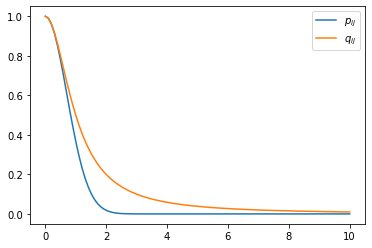

In [4]:
# plot p_ij and q_ij as a function of high/low distances
x = y = np.linspace(0,10,100)
p = np.exp(-x**2)
q = 1./(1+ x**2)

plt.plot(x, p)
plt.plot(x, q)
_=plt.legend(['$p_{ij}$', '$q_{ij}$'])

The intuition here is to note that the distribution $q_{ij}$ has a heavier tail than distribution $p_{ij}$. As a result, to have the same probability in low and high dimension, the distance need to be greater in the low dimension than in the high dimension; or as Maaten puts it: "this allows a moderate distance in the high-dimensional space to be faithfully modeled by a much larger distance in the map and, as a result, it eliminates the unwanted attractive forces between map points that represent moderately dissimilar datapoints."

This minimisation of performed through gradient descent. The analytical expression for the gradient of the cost is given by:

$$\frac{\partial C}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j)(1+\lVert y_i - y_j \rVert^2)^{-1}$$

This is usually split in two parts, with attractive forces (generating a positive gradient) and repulsive forces (generating a negative gradient):

$$
\frac{\partial C}{\partial y_i} = 4 ( E * F_{attr} + F_{rep}) 
= 4 Z (E * \sum_{j \neq i} p_{ij}q_{ij} (\boldsymbol y_i - \boldsymbol y_j) - \sum_{j \neq i} q_{ij}^2 (\boldsymbol y_i - \boldsymbol y_j))
$$

$Z$ is a normalisation factor equal to $Z = \sum_{k \neq l} (1+ \lVert y_k - y_l \rVert^2)^{-1}$. One of the trick in t-SNE for ensuring a good optimisation is called "early exaggeration" and consists in scaling the attractive forces by a factor $E$, typically equal to $12$, for a finite amount of gradient updates before setting the scaling back to unity.

This can be plotted for one interaction between indice $i$ and $j$. Hence, we can remove the summation:

$$\frac{\partial C_j}{\partial y_i} = \frac{E y \exp(-x^2/P)}{1+y^2} - \frac{y}{(1+y^2)^2}$$

$$x = d(\boldsymbol x_i, \boldsymbol x_j), y = d(\boldsymbol y_i, \boldsymbol y_j)$$

$E$ and $P$ are constants which are related to early exaggeration and perplexity, respectively.


In [65]:
# plot the gradient of the cost as a function of high/low distances and normalisation constants
def plot_gradient(E, P, N):

    def gradient(x, y):
        A = E * y * np.exp(-x**2/P) / (1+y**2)
        B = y / (1+y**2)**2
        return A - B

    N = N
    x = np.linspace(0,10,N)
    y = np.linspace(0,10,N)
    X,Y = np.meshgrid(x, y) # grid of point

    Z = gradient(X, Y) # evaluation of the function on the grid
    
    fig, ax = plt.subplots(figsize=(6,6))
    res = ax.pcolor(x, y, Z, cmap=cm.RdBu)
    
    CS = ax.contour(X, Y, Z, colors='k')
    ax.clabel(CS, inline=1, fontsize=10)
    
    ax.set_ylabel('low-D distance')
    ax.set_xlabel('high-D distance')
    fig.colorbar(res, ax=ax)

w = interactive(plot_gradient, E=IntSlider(1,1,10), P=IntSlider(1,1,10), 
                N=IntSlider(50,10,100), continuous_update=False)

display(w)

interactive(children=(IntSlider(value=1, description='E', max=10, min=1), IntSlider(value=1, description='P', …

This computation has proven succesful in producing embedding of high quality, but the computation cost has been prohibitive for large dataset, due to the nature of the algrotithm. Indeed, to compute the gradient for 1 point, all interaction with other points need to be taken into account, giving a $N^2$ performance.

A series of improvments have been proposed to remediate to this problem.

# 2. Force layout

References:
3. Fruchterman, T. M. J., & Reingold, E. M. (1991). Graph drawing by force-directed placement. Software: Practice and Experience, 21(11), 1129–1164. https://doi.org/10.1002/spe.4380211102
4. Zheng, J. X. S., Pawar, S., & Goodman, D. F. M. (2018). Graph Drawing by Stochastic Gradient Descent. IEEE Transactions on Visualization and Computer Graphics, 1–1. https://doi.org/10.1109/TVCG.2018.2859997
5. Dwyer, T., Koren, Y., & Marriott, K. (2009). Constrained graph layout by stress majorization and gradient projection. Discrete Mathematics, 309(7), 1895–1908. https://doi.org/10.1016/J.DISC.2007.12.103
6. Gansner, E. R., Koren, Y., & North, S. (2005). Graph Drawing by Stress Majorization (pp. 239–250). Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-540-31843-9_25
7. Jacomy, M., Venturini, T., Heymann, S., & Bastian, M. (2014). ForceAtlas2, a Continuous Graph Layout Algorithm for Handy Network Visualization Designed for the Gephi Software. PLoS ONE, 9(6), e98679. https://doi.org/10.1371/journal.pone.0098679

A natural question comes to mind: how do force based layouts differ from t-SNE?

Starting with a paper from Fruchterman [3]:

"Eades modelled a graph as a physical system of rings and springs, but his implemen- tation did not reflect Hooke’s law; rather, he chose his own formula for the forces exerted by the springs. Another important deviation from the physical reality is the application of the forces: repulsive forces are calculated between every pair of vertices, but attractive forces are calculated only between neighbours. This reduces the time complexity because calculating the attractive forces between neighbours is thus $\mathcal{O}(E)$, although the repulsive force calculation is still $\mathcal{O}(V^2)$, a great weakness of these n-body algorithms (however, see Greengard).
Kamada and Kawai have their own variant on Eades’ algorithm. They also modelled a graph as a system of springs, but whereas Eades abandoned Hooke’s law, Kamada and Kawai solved partial differential equations based on it to optimize layout. Eades decided that it was important only for a vertex to be near its immediate neighbors and so calculated attractive forces only between neighbours, but Kamada and Kawai’s algorithm adds the concept of an ideal distance between vertices that are not neighbours: the ideal distance between two vertices is proportional to the length."

As we can see, either a potential is defined or a set of forces - with the latter being the derivative of the former. The main expression for the cost is given by:

$$stress(\mathbf X) = \sum_{i<j} \omega_{ij} (d(\boldsymbol x_i, \boldsymbol x_j) - d(\boldsymbol y_i, \boldsymbol y_j))^2$$
$$\omega_{ij} = d(\boldsymbol y_i, \boldsymbol y_j))^{-\alpha}, \alpha \in {0,1,2}$$

where here the convention is changed and $\boldsymbol x, \boldsymbol y$ represent the low and high dimensional embedding, respectively. The idea behind the formula of the stress is to find an embedding which conserves the distances of the high dimensional space. This is commonly used in the literature related to graph layout and multi-dimensional scaling (MDS), see [4,5,6]. 

Different approaches are used to minimise the stress of the layout. Some recent work has tried to find solutions to the stress minimisation by using a majoration approach, e.g. [5,6]. This is usually very involved mathematically. A more recent approach has been using gradient descent, e.g [4]. 

The expression of the gradient is given by:

$$
\frac{\partial stress_i}{\partial x_i} = 
2 \sum_i \omega_{ij} \frac{\boldsymbol x_i - \boldsymbol x_j}{\lVert \boldsymbol x_i - \boldsymbol x_j \rVert}
(\lVert \boldsymbol x_i - \boldsymbol x_j \rVert - d_{ij})
$$

$$d_{ij} = d(\boldsymbol y_i, \boldsymbol y_j)$$

This gradient can be plotted in a similar fashion as a function of high and low dimensional distances and the constant $\alpha$:

In [68]:
# plot the gradient of the cost as a function of high/low distances and normalisation constants
def plot_gradient(alpha, N):
    EPSILON = np.finfo(np.float64).eps

    def gradient(x, y):
        return (x - y) / (y+1)**alpha

    N = N
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    X,Y = np.meshgrid(x, y) # grid of point

    Z = gradient(X, Y) # evaluation of the function on the grid
    
    fig, ax = plt.subplots(figsize=(6,6))
    res = ax.pcolor(x, y, Z, cmap=cm.RdBu)

    CS = ax.contour(X, Y, Z, colors='k')
    ax.clabel(CS, inline=1, fontsize=10)
        
    ax.set_ylabel('low-D distance')
    ax.set_xlabel('high-D distance')
    fig.colorbar(res, ax=ax)

w = interactive(plot_gradient, alpha=IntSlider(2, 0,2), N=IntSlider(50,10,100), continuous_update=False)

display(w)

interactive(children=(IntSlider(value=2, description='alpha', max=2), IntSlider(value=50, description='N', min…

Finding a solution to the stress minimisation has been portrayed as an N-body problem. It is possible to defined equations of motions as partial ODEs which are solved by integration. The integration method has an impact on computational cost and most work resolve to approximation of the integration (Newton-Raphson, Runge-Kutta, ...).

It is interesting to note that two equivalent view can be taken. In the first one, the layout is optimised by considering the placement of individual nodes on the layout. Considering that all nodes are connected to all other nodes, this incurs an $N^2$ cost for the optimisation. The similar ideas to this is to consider that the graph is instead best described as a collection of edges, and that the optimisation should update one edge at a time.

Finally, in constrast to defining a cost, there has also been some attempts to design forces directly, such that the layout would gain desired properties. One such example is given in [7].

# 3. Differences and similarities between t-SNE and force

## 3.1 Relation between integration of ODEs and gradient descent

https://en.wikipedia.org/wiki/Verlet_integration

The equations for the integration are simple:

$$x(t+dt) = x(t) + v(t)dt + a(t)dt^2/2$$
$$v(t+dt) = v(t) + (a(t) + a(t+dt))dt/2$$

These should be compared to the one of gradient descent with momentum. In [1], the equation chosen is:

$$x(t) = x(t-1) + \eta \frac{\partial{C}}{\partial x} + \alpha (x(t-1) - x(t-2))$$

There are some variations, but the main idea is that the accumulation of the gradient (hence the term momentum) plays the same role as an integration.

## 3.2 Difference between the cost/forces

As illustrated by plotting the gradient for both type of cost, KL divergence for t-SNE and stress for force based layout, one can observe that they have very dissimilar goals. While t-SNE gradient structure seek to place point close in high-D close in low-D and repulse points far in high-D to point close in high-D - in other words making sure that the small scale structure is preserved, force based seeks to place all points in low-D at a similar distance in high-D.

There is a complete lack of models for long-range interactions in t-SNE as can be seen by the absence of gradient for any interactions that does not contains points close in low-D or high-D.

# 4. Performance improvements in t-SNE

References:
8. Dong, W., Moses, C., & Li, K. (2011). Efficient k-nearest neighbor graph construction for generic similarity measures, 577. https://doi.org/10.1145/1963405.1963487
9. Malkov, Y. A., & Yashunin, D. A. (2016). Efficient and robust approximate nearest neighbor search using Hierarchical Navigable Small World graphs. Retrieved from http://arxiv.org/abs/1603.09320
10. Linderman, G. C., Rachh, M., Hoskins, J. G., Steinerberger, S., & Kluger, Y. (2017). Efficient Algorithms for t-distributed Stochastic Neighborhood Embedding. https://doi.org/10.1038/s41592-018-0308-4
11. Pezzotti, N., Mordvintsev, A., Hollt, T., Lelieveldt, B. P. F., Eisemann, E., & Vilanova, A. (2018). Linear tSNE optimization for the Web. Retrieved from http://arxiv.org/abs/1805.10817
12. Pezzotti, N., Höllt, T., Lelieveldt, B., Eisemann, E., & Vilanova, A. (2016). Hierarchical Stochastic Neighbor Embedding. Computer Graphics Forum, 35(3), 21–30. https://doi.org/10.1111/cgf.12878


## 4.1 Attractive forces
Tree based approximation [2], Appoximate nearest neighbhours [8,9,10].

ANN has become a very important part of the machine learning community. Approximate nearest neighbhour search is encountered for the task of finding objects similar to a given item in a dataset when the size of the dataset prevents an exhaustive search due to performance concern. This is typically the case for recommender systems where the time constrain is enforce by user interaction and the dataset contains millions of samples (music, photos, ...). This has lead to the development of benchmark for evaluating the performance of ANN algorithms, see http://ann-benchmarks.com/. The performance is computed as the number of queries per unit of time given the recall.

One solution for t-SNE is to compute a set of nearest neighbhour, some results have shown that approximate neighbhours do not degrade performance, as Linderman puts it:
"A recent theoretical advance by Linderman et al. (2017) can be used to optimize this step: it
suggests that connecting every point to its (for example) k = 100 nearest neighbors is not more effective than connecting every point to 2 randomly chosen points out of its 100 nearest neighbors. **The main reason is that this randomized procedure, when executed on point clouds lying on manifolds, creates expander graphs at the local scale which represent the local geometry accurately at a slightly coarser level.**"

## 4.2 Repulsive forces
Tree based approximation and interpolation [10].

Improving on the computation of the repulsive force with a polynomial interpolation.
https://gauss.math.yale.edu/~gcl22/blog/numerics/low-rank/t-sne/2018/01/11/low-rank-kernels.html

The state of the art implementation in Python is available at:
- https://github.com/pavlin-policar/openTSNE
- https://github.com/KlugerLab/FIt-SNE

## 4.3 GPU
Another complete rehaul of t-SNE with a quite different approach has been proposed by Pezotti [11].
This is very different approach to some extent. The idea is to compute the attractive force as a scalar field and the repulsive force as a vector field.

See:
- https://github.com/tensorflow/tfjs-tsne
- https://nicola17.github.io/tfjs-tsne-demo/

## 4.4 Hierarchical embedding
Pezotti again proposed to use hierarchical embedding with interpolation.

## 4.5 Optimisation parameters
Some works has recently looked into what happens during the optimisation and how parameters such as early exaggeration influence the results.

# 5. Art of using t-SNE, and beyond

There is a bit of literature on how to use t-SNE effectively.

13. https://distill.pub/2016/misread-tsne/

14. Kobak, D., & Berens, P. (2018). The art of using t-SNE for single-cell transcriptomics. BioRxiv, 453449. https://doi.org/10.1101/453449

15. Belkina, A. C., Ciccolella, C. O., Anno, R., Halpert, R., Spidlen, J., & Snyder-Cappione, J. E. (2018). Automated Optimal Parameters for T-Distributed Stochastic Neighbor Embedding Improve Visualization and Allow Analysis of Large Datasets. BioRxiv, 451690. https://doi.org/10.1101/451690

16. Linderman, G. C., & Steinerberger, S. (2019). Clustering with t-SNE, Provably. SIAM Journal on Mathematics of Data Science, 1(2), 313–332. https://doi.org/10.1137/18M1216134

# 6. Findings and opportunities

The data provided in ANN papers shows that for dataset with a large number of dimensions ($N>50$), the performance degrades dramatically. There might be an opportunity to introduce random sampling techniques.

The data provided in [15] shows that the default optimisation parameters for t-SNE are suboptimal, it is however shown than early exaggeration is an important part. Novel initialisation techniques such as spectral embedding might allow for a speed up.
